In [1]:

import numpy as np
from util.plot import plot_cdf,color_list,plot_cdf_sub
from util.func import decode_dict,map_percentiles
from util.consts import MTU,UNIT_G,LINK_TO_DELAY_DICT,SIZE_BUCKET_LIST_OUTPUT,get_base_delay_transmission,get_base_delay,get_size_bucket_list_output,SIZE_BUCKET_LIST_LABEL_OUTPUT
import json
import pandas as pd
import re
from collections import defaultdict

In [2]:
dir_input="/data2/lichenni/path_perflow_lognormal"
topo_type="_topo-pl-x_"
lr=10
data_list=[]
# for shard in np.arange(1000):
for shard in [0]:
    for n_flows in [20000]:
        for n_hosts in [3]:
            for shard_seed in [0]:
                topo_type_cur=topo_type.replace("-x_",f"-{n_hosts}_")+"s%d"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                dir_input_tmp = f"{dir_input}/{spec}"
                
                fat = np.load(f'{dir_input}/{spec}/fat.npy')
                fct = np.load(f'{dir_input}/{spec}/fct{topo_type_cur}.npy')
                if len(fat) == len(fct):
                    data_list.append((spec,topo_type_cur))
print(f"len(data_list): {len(data_list)}")
# Define a pattern to match the log line
log_pattern = re.compile(r"(\d+)\s+n:(\d+)\s+(\d+):(\d+)\s+(\d+)\s+(\w+)\s+ecn:(\d+)\s+(0b[0-9a-f]+)\s+(0b[0-9a-f]+)\s+(\d+)\s+(\d+)\s+(\w+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\((\d+)\)\s+(\d+)")
# Create a DataFrame
columns = ["timestamp", "node", "src_port", "queue", "queue_length", "event", "ecn", "src_addr", "dst_addr", 
           "src_port_num", "dst_port_num", "packet_type", "seq_num", "tx_timestamp", "priority_group", "packet_size", 
           "payload_size", "flow_id"]

len(data_list): 1


In [20]:
num_active_flows_list=[]
for spec_idx,(spec,topo_type) in enumerate(data_list):
    print(f"spec_idx: {spec_idx}")
    input_tmp=f"{dir_input}/{spec}"
    # List to hold parsed log data
    log_data = []

    # Read the log file
    with open(f'{input_tmp}/mix{topo_type}.log', 'r') as file:
        log_data = [match.groups() for line in file if (match := log_pattern.match(line))]


    df = pd.DataFrame(log_data, columns=columns)

    # Convert relevant columns to appropriate data types
    df["timestamp"] = pd.to_numeric(df["timestamp"])
    df["seq_num"] = pd.to_numeric(df["seq_num"])
    df["flow_id"] = pd.to_numeric(df["flow_id"])

    fat = np.load(f'{input_tmp}/fat.npy')
    fct = np.load(f'{input_tmp}/fct{topo_type}.npy')
    ftt=fat+fct
    # Combine fat and fct into a DataFrame
    flow_end_time_dict = {flow_id: end_time for flow_id, end_time in enumerate(ftt)}

    # Identify busy periods
    busy_periods = []
    flows=[]
    current_period = None

    for _, row in df.iterrows():
        seq_num = row["seq_num"]
        timestamp = row["timestamp"]
        flow_id = row["flow_id"]
        if seq_num == 1:
            if current_period is not None:
                assert "current_period is not None"
            current_period = {"start": timestamp, "end": None}
        elif seq_num == 2 and current_period is not None:
            # End of the current busy period
            current_period["end"] = timestamp
            busy_periods.append(current_period)
            current_period = None
        elif seq_num == 0:
            end_time = flow_end_time_dict.get(flow_id, None)
            flows.append((flow_id, timestamp, flow_end_time_dict[flow_id]))
        else:
            assert "Invalid seq_num"

    # Add the last period if still open
    if current_period is not None:
        current_period["end"]=60000000000
        busy_periods.append(current_period)

    # Output the number of active flows for each busy period
    num_active_flows_list_tmp = []
    for period in busy_periods:
        start, end = period["start"], period["end"]
        active_flows = set(flow_id for flow_id, start_time, end_time in flows if start_time <= end and end_time >= start)
        num_active_flows = len(active_flows)
        num_active_flows_list_tmp.append(num_active_flows)
        print(f"start: {start}, end: {end}, num_active_flows: {num_active_flows}")
    num_active_flows_list.append(num_active_flows_list_tmp)
      


spec_idx: 0
start: 1000175032, end: 1000202790, num_active_flows: 4
start: 1000205304, end: 1000709270, num_active_flows: 3
start: 1001115991, end: 1001865484, num_active_flows: 25
start: 1001930568, end: 1002100431, num_active_flows: 5
start: 1002163128, end: 1002252148, num_active_flows: 6
start: 1002258852, end: 1002366826, num_active_flows: 2
start: 1002410402, end: 1002671375, num_active_flows: 8
start: 1002890382, end: 1003165759, num_active_flows: 10
start: 1003188385, end: 1003345618, num_active_flows: 3
start: 1003347111, end: 1003348604, num_active_flows: 3
start: 1003664900, end: 1003690075, num_active_flows: 3
start: 1003693314, end: 1003694990, num_active_flows: 3
start: 1003696066, end: 1003812648, num_active_flows: 6
start: 1003968538, end: 1004432859, num_active_flows: 13
start: 1005389743, end: 1006224674, num_active_flows: 26
start: 1007618715, end: 1007708148, num_active_flows: 4
start: 1007782137, end: 1007834950, num_active_flows: 3
start: 1008292736, end: 10085469

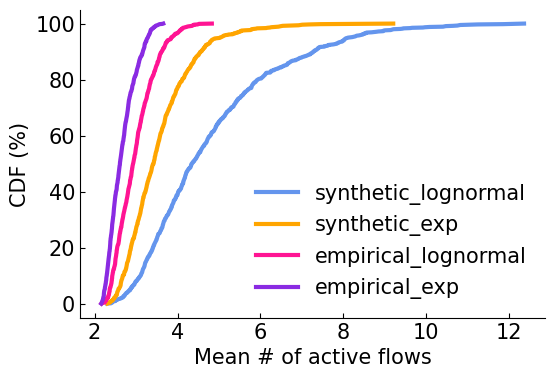

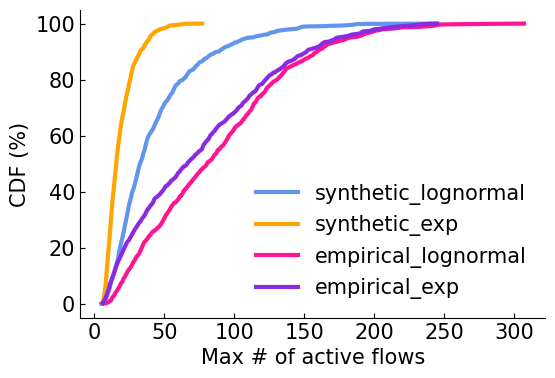

In [2]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
res_mean=[]
res_max=[]
for target_str in target_str_list:
    result_file=f'./res/num_active_flows_queue{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    
    res_tmp=[]
    for tmp in num_active_flows_list:
        res_tmp.append(np.mean(tmp))
    res_mean.append(np.array(res_tmp))
    
    res_tmp=[]
    for tmp in num_active_flows_list:
        res_tmp.append(np.max(tmp))
    res_max.append(np.array(res_tmp))
plot_cdf(res_mean,None,legend_list,'Mean # of active flows',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
fig_idx+=1
plot_cdf(res_max,None,legend_list,'Max # of active flows',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)


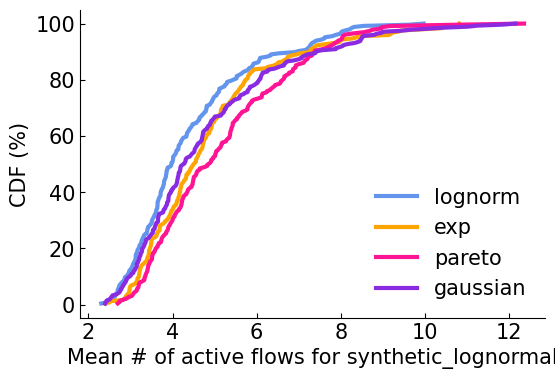

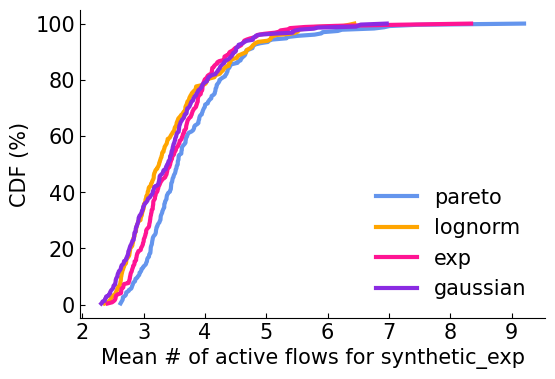

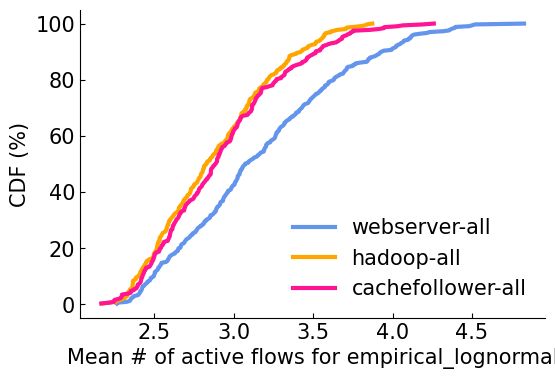

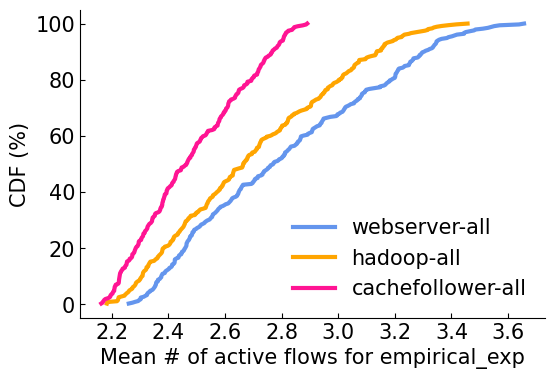

In [8]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
target_legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
for target_idx, target_str in enumerate(target_str_list):
    
    res_dict=defaultdict(list)
    
    result_file=f'./res/num_active_flows_queue{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    flow_sizes_list = results["flow_sizes"]
    
    for flow_size_idx,flow_sizes in enumerate(flow_sizes_list):
        res_dict[flow_sizes].append(np.mean(num_active_flows_list[flow_size_idx]))
    
    legend_list=list(res_dict.keys())
    plot_data=[np.array(res_dict[flow_sizes]) for flow_sizes in legend_list]
    plot_cdf(plot_data,None,legend_list,f'Mean # of active flows for {target_legend_list[target_idx]}',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1

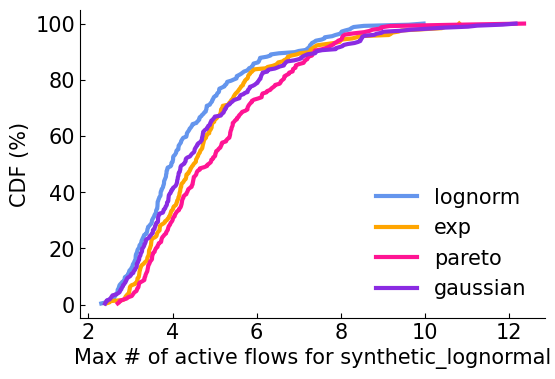

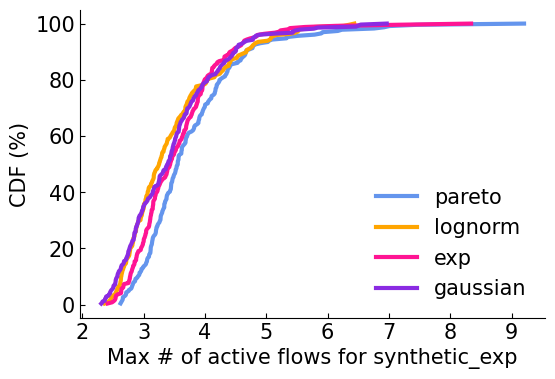

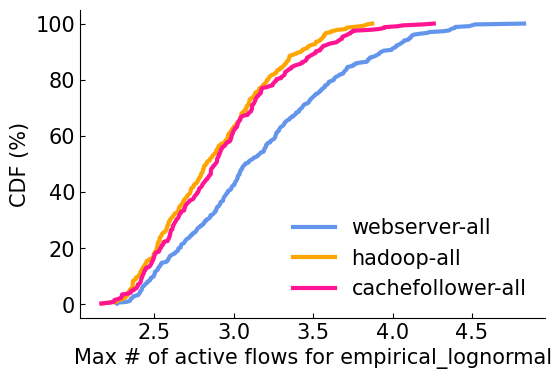

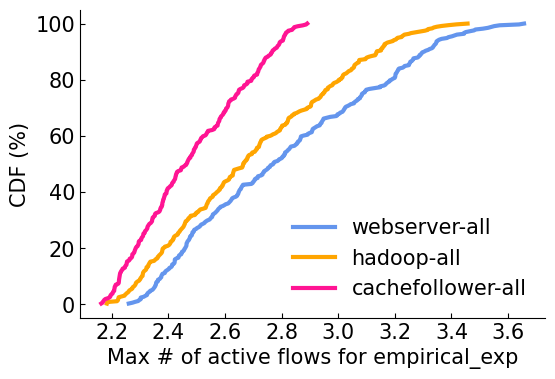

In [7]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
target_legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
for target_idx, target_str in enumerate(target_str_list):
    
    res_dict=defaultdict(list)
    
    result_file=f'./res/num_active_flows_queue{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    flow_sizes_list = results["flow_sizes"]
    
    for flow_size_idx,flow_sizes in enumerate(flow_sizes_list):
        res_dict[flow_sizes].append(np.max(num_active_flows_list[flow_size_idx]))
    
    legend_list=list(res_dict.keys())
    plot_data=[np.array(res_dict[flow_sizes]) for flow_sizes in legend_list]
    plot_cdf(plot_data,None,legend_list,f'Max # of active flows for {target_legend_list[target_idx]}',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1

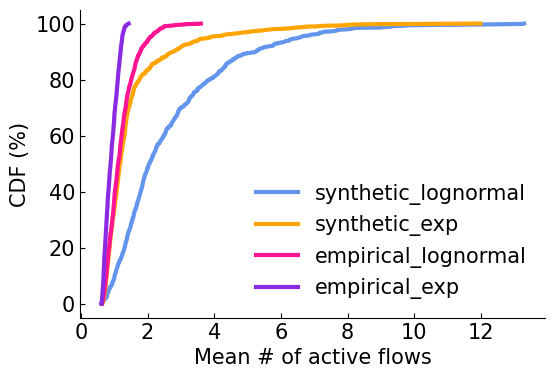

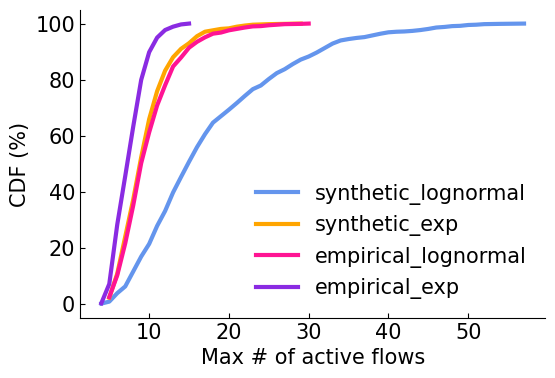

In [5]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
res_mean=[]
res_max=[]
for target_str in target_str_list:
    result_file=f'./res/num_active_flows_time{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    
    res_tmp=[]
    for tmp in num_active_flows_list:
        res_tmp.append(np.mean(tmp))
    res_mean.append(np.array(res_tmp))
    
    res_tmp=[]
    for tmp in num_active_flows_list:
        res_tmp.append(np.max(tmp))
    res_max.append(np.array(res_tmp))
    
plot_cdf(res_mean,None,legend_list,'Mean # of active flows',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
fig_idx+=1

plot_cdf(res_max,None,legend_list,'Max # of active flows',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)

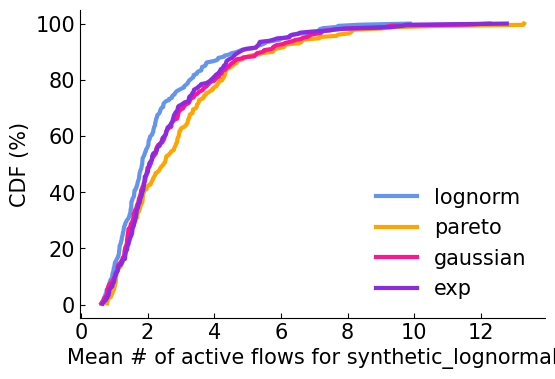

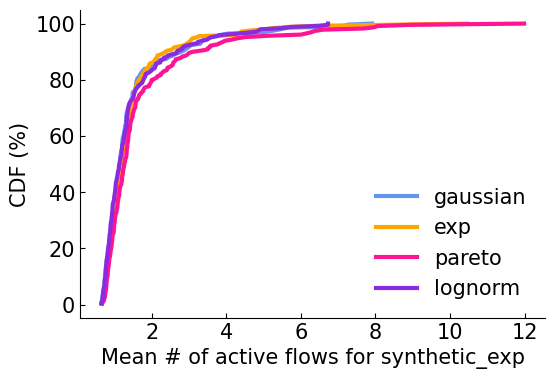

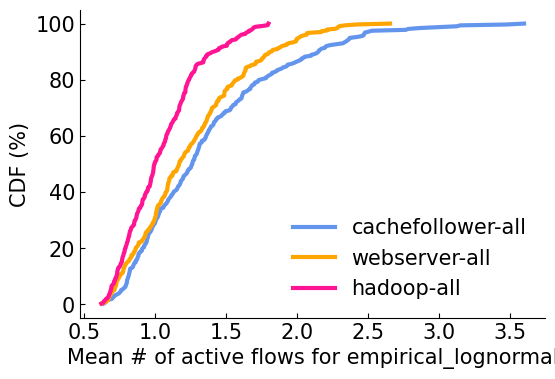

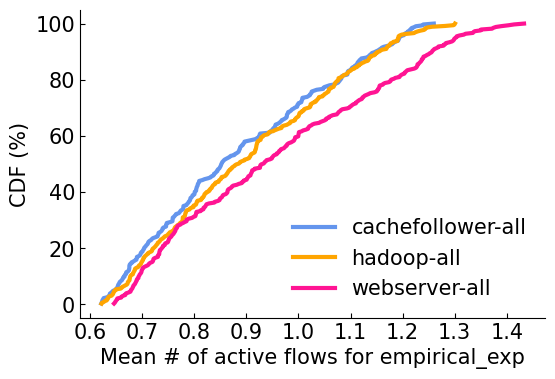

In [9]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
target_legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
for target_idx,target_str in enumerate(target_str_list):
    res_dict=defaultdict(list)
    
    result_file=f'./res/num_active_flows_time{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    flow_sizes_list = results["flow_sizes"]
    
    for flow_size_idx,flow_sizes in enumerate(flow_sizes_list):
        res_dict[flow_sizes].append(np.mean(num_active_flows_list[flow_size_idx]))
    
    legend_list=list(res_dict.keys())
    plot_data=[np.array(res_dict[flow_sizes]) for flow_sizes in legend_list]
    plot_cdf(plot_data,None,legend_list,f'Mean # of active flows for {target_legend_list[target_idx]}',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1

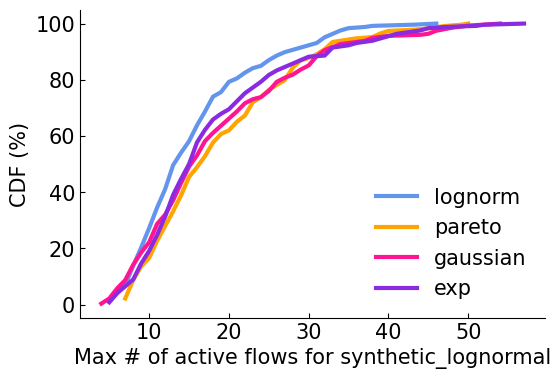

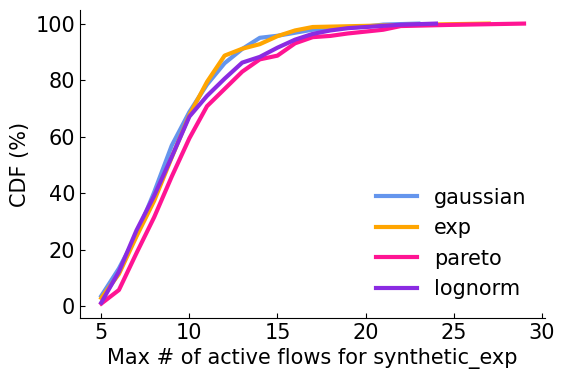

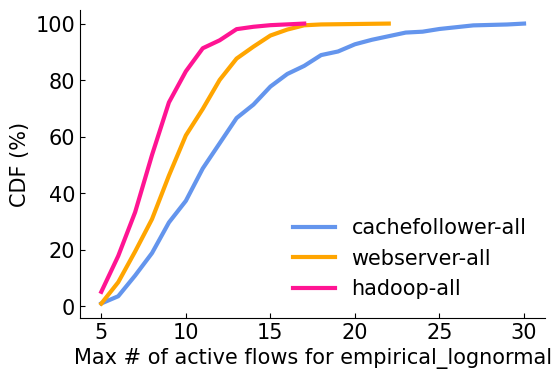

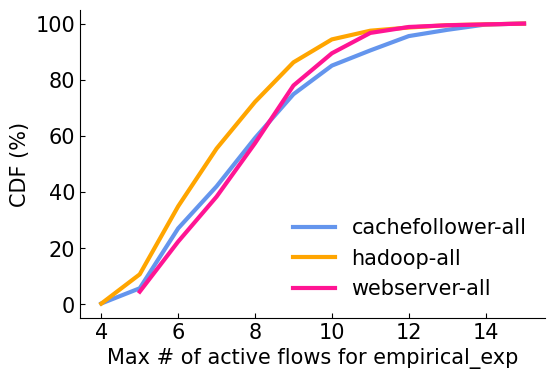

In [6]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
target_legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
for target_idx,target_str in enumerate(target_str_list):
    res_dict=defaultdict(list)
    
    result_file=f'./res/num_active_flows_time{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    flow_sizes_list = results["flow_sizes"]
    
    for flow_size_idx,flow_sizes in enumerate(flow_sizes_list):
        res_dict[flow_sizes].append(np.max(num_active_flows_list[flow_size_idx]))
    
    legend_list=list(res_dict.keys())
    plot_data=[np.array(res_dict[flow_sizes]) for flow_sizes in legend_list]
    plot_cdf(plot_data,None,legend_list,f'Max # of active flows for {target_legend_list[target_idx]}',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1

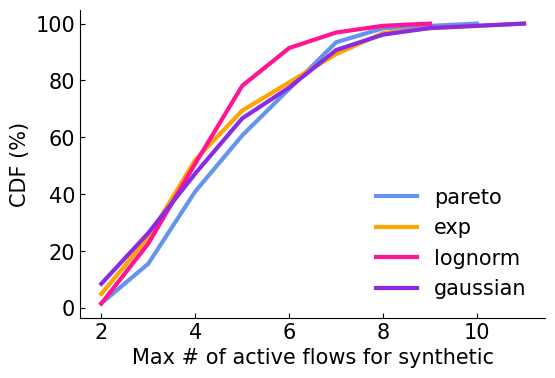

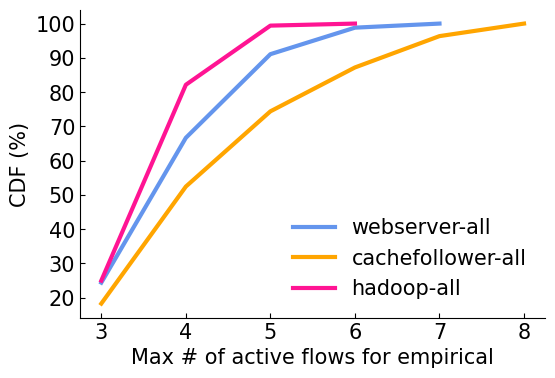

In [14]:
# target_str_list=["_busy_close","_busy_close_empirical"]
target_str_list=["_busy","_busy_empirical"]
# target_str_list=["_busy_close"]
target_legend_list=["synthetic","empirical"]

fig_idx=0
for target_idx,target_str in enumerate(target_str_list):
    res_dict=defaultdict(list)
    
    result_file=f'./res/num_active_flows_time{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    flow_sizes_list = results["flow_sizes"]
    for flow_size_idx,flow_sizes in enumerate(flow_sizes_list):
        # res_dict[flow_sizes].extend((num_active_flows_list[flow_size_idx]))
        res_dict[flow_sizes].append(np.max(num_active_flows_list[flow_size_idx]))
    legend_list=list(res_dict.keys())
    plot_data=[np.array(res_dict[flow_sizes]) for flow_sizes in legend_list]
    plot_cdf(plot_data,None,legend_list,f'Max # of active flows for {target_legend_list[target_idx]}',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1